In [75]:
import math
import os
import re
import tkinter
from tkinter import filedialog
from tkinter import Tk
import matplotlib
from regions import Regions

import astropy
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
import photutils
import pyregion
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
from photutils.background import Background2D, SExtractorBackground
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

tkinter.Tk().withdraw()


root = Tk()
root.withdraw()  


''

In [3]:

def GenerateCutouts(hdulist, ds9regionlist):
    """
    Generate cutouts from a given list of DS9 regions.

    Parameters:
    - hdulist (astropy.io.fits.HDUList): The input FITS file containing the data.
    - ds9regionlist (list): A list of DS9 regions.

    Returns:
    - cutouts_list (list): An list of hdul objects for every cutout
    """
    data = hdulist[0].data
    header = hdulist[0].header
    wcs = WCS(header)
    cutouts_list = []

    for i in range(len(ds9regionlist)):        
        if hasattr(ds9regionlist[i], 'to_pixel') == True:
            region_in_pix = ds9regionlist[i].to_pixel(wcs)
        else:
            region_in_pix = ds9regionlist[i]

        cutout_center_cord = region_in_pix.center.xy
        cutout_size = region_in_pix.height

        cutout = Cutout2D(data, cutout_center_cord, cutout_size, wcs=wcs)
        cutout_header = cutout.wcs.to_header()

        hdul = fits.HDUList([fits.PrimaryHDU(cutout.data, cutout_header)])
        
        cutouts_list.append(hdul)

    return cutouts_list


def GetBackground(hdulist):
    """
    Calculate the background of an astronomical image.

    Parameters:
    - hdulist (HDUList): The input FITS file as an HDUList object.

    Returns:
    - bkg (Background2D): The calculated background as a Background2D object.
    """
    
    data=hdulist[0].data
    header=hdulist[0].header
    wcs = WCS(header)

    coverage_mask = np.isnan(data)
    sigma_clip = SigmaClip(sigma=3, maxiters=10000, grow=1)
    bkg_estimator = SExtractorBackground()
    threshold = detect_threshold(data, nsigma=2.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(data, threshold, npixels=10)
    footprint = circular_footprint(radius=5)
    mask = segment_img.make_source_mask(footprint=footprint)

    bkg = Background2D(data, (5,5), 
                    mask=mask,
                    sigma_clip=sigma_clip, 
                    bkg_estimator=bkg_estimator, 
                    exclude_percentile=10.0, 
                    coverage_mask=coverage_mask, 
                    fill_value='NaN')
    
    return bkg


def SubtractBG(hdulist):
    """
    Subtract the background from the input HDUList.

    Parameters:
    - hdulist (astropy.io.fits.HDUList): The input HDUList containing the data and header.

    Returns:
    - hdulist_BGS (astropy.io.fits.HDUList): The HDUList with the background subtracted data.

    """
    data = hdulist[0].data
    header = hdulist[0].header
    wcs = WCS(header)

    bkg = GetBackground(hdulist)
    data_bgsub = data - bkg.background
    hdu = fits.PrimaryHDU(data_bgsub, header=header)
    hdulist_BGS = fits.HDUList([hdu])
    return hdulist_BGS

def GetBGrms(hdulist):
    """
    Calculate the background RMS value for a given FITS file.

    Parameters:
    - hdulist (HDUList): The FITS file to calculate the background RMS for.

    Returns:
    - float: The background RMS value.

    """
    data = hdulist[0].data
    header = hdulist[0].header
    wcs = WCS(header)

    bkg = GetBackground(hdulist)
    return bkg.background_rms_median

def GenerateErrorMap(scifile_hdulist, scifile_co_hdulist, whtfile_co_hdulist):
    """
    Generate an error map based on the input science and weight data.

    Parameters:
    - scifile_hdulist (HDUList): HDUList object containing the science file data.
    - scifile_co_hdulist (HDUList): HDUList object containing the science coutout file data.
    - whtfile_co_hdulist (HDUList): HDUList object containing the weight cutout file data.

    Returns:
    - ErrorMap_HDUlist (HDUList): HDUList object containing the generated error map data.

    """

    ccdgain = scifile_hdulist[0].header['CCDGAIN']

    sci_co_data = scifile_co_hdulist[0].data
    wht_co_data = whtfile_co_hdulist[0].data

    sigma_ped = GetBGrms(scifile_co_hdulist)

    print("sigma_pedestal = ", sigma_ped)

    errForZeroWhtPix = 100.

    # Poisson noise from astrophysical sources

    # for cps
    poissonIm = np.where(wht_co_data > 0., np.sqrt(np.abs(sci_co_data) / (wht_co_data * ccdgain)), float('nan'))

    # for counts
    # poissonIm = numpy.where (wht_co_data>0., numpy.sqrt((numpy.abs(sci_co_data) * wht_co_data) / ccdgain), float('nan'))  for cps instead of counts

    ## If Poisson > 2*Pedestal, add Poisson and Pedestal in quadrature.  Else use Pedestal.

    ErrorMap_data = np.where(poissonIm > 2 * sigma_ped, np.sqrt(poissonIm ** 2 + sigma_ped ** 2), sigma_ped)
    ErrorMap_data = np.where(wht_co_data > 0, ErrorMap_data, errForZeroWhtPix)  # for lanczos3
    # ErrorMap_data = numpy.where (wht_co_data != 0, ErrorMap_data, errForZeroWhtPix) #for square

    # copy the fits header from original wht image, and add another keyword (SHS_INFO) to specify that it's a sigma image
    ErrorMap_header = whtfile_co_hdulist[0].header

    primaryhdu = fits.PrimaryHDU(ErrorMap_data, ErrorMap_header)
    primaryhdu.header.update(SHS_INFO="sigma")
    ErrorMap_HDUlist = fits.HDUList([primaryhdu])
    return ErrorMap_HDUlist

We first open the three files required to build the error map:

`scifile_orig`: The original SCI file containing the header

`scifile_co`: The cutout of the SCI file to generate the errormap from (can be made using the `GenerateCutout` function)

`whtfile_co`: The cutout of the WHT file to generate the errormap from (can be made using the `GenerateCutout` function)

In [4]:
scifile_orig = fits.open(filedialog.askopenfilename(title='Select the original science file'))
scifile_co = fits.open(filedialog.askopenfilename(title='Select the cutout science file'))
whtfile_co = fits.open(filedialog.askopenfilename(title='Select the cutout weight file'))





In [7]:
# read in the sci (cutout) and the weight (cutout) image
sciIm = scifile_co[0].data
whtIm = whtfile_co[0].data

First think we would like to do is mask the sources in our data. For this we use an interative sigma clipping procedure.

> One method to create a source mask is to use a segmentation image. Here we use the detect_threshold convenience function to get a rough estimate of the threshold at the 2-sigma background noise level. Then we use the detect_sources function to generate a SegmentationImage. Finally, we use the make_source_mask() method with a circular dilation footprint to create the source mask:

In [8]:
coverage_mask = np.isnan(sciIm) 
sigma_clip = SigmaClip(sigma=3, maxiters=10000, grow=1)
bkg_estimator = SExtractorBackground()
threshold = detect_threshold(sciIm, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(sciIm, threshold, npixels=10)
footprint = circular_footprint(radius=5)
mask = segment_img.make_source_mask(footprint=footprint)

bkg = Background2D(sciIm, (5,5), 
                mask=mask,
                sigma_clip=sigma_clip, 
                bkg_estimator=bkg_estimator, 
                exclude_percentile=10.0, 
                coverage_mask=coverage_mask, 
                fill_value='NaN')


Let's take a look at what this does:

We plot first our science cutout:

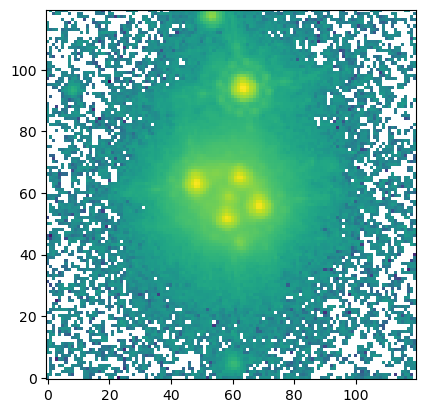

In [38]:
sciIm_obj = plt.imshow(sciIm, origin='lower', norm=LogNorm())

Now let's see what parts of this image are covered by the mask

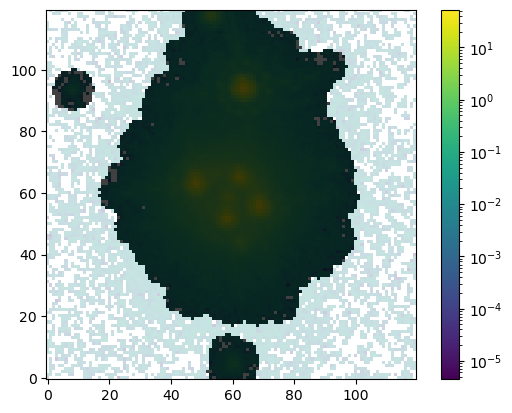

In [40]:
sciIm_obj = plt.imshow(sciIm, origin='lower', norm=LogNorm())
plt.imshow(mask, origin='lower', cmap='gray_r', alpha=0.75)
plt.colorbar(sciIm_obj)



We can see the sources are covered! Now let's see what parts of the background are actually considered for background computation. We will plot the grid generated with `Background2D`. Basically dividing the data in 5x5 squares, and if more than 10% of the data in one of these squares is covered, it is excluded. Squares with a dot in the middle are those considered

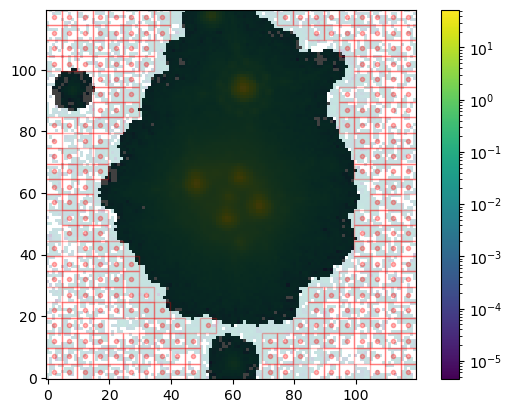

In [42]:
sciIm_obj = plt.imshow(sciIm, origin='lower', norm=LogNorm()GenerateCutoutsAndErrorMaps)
plt.imshow(mask, origin='lower', cmap='gray_r', alpha=0.75)
plt.colorbar(sciIm_obj)


bkg.plot_meshes(outlines=True, marker='.', color='red', alpha=0.3)

plt.show()

Now we can compute the median RMS from all this small source-less squares. We do that by:

In [62]:
sigma_ped= bkg.background_rms_median
bkg.background_rms_median

0.009587907410409538

And now we can use this value as the sigma pedestal to generate the errormap.

In [64]:
ccdgain = scifile_orig[0].header['CCDGAIN']
errForZeroWhtPix = 100. #to discard the pixels with zero weight


In [71]:
# Poisson noise from astrophysical sources

# for cps
poissonIm = np.where(whtIm > 0., np.sqrt(np.abs(sciIm) / (whtIm * ccdgain)), float('nan'))
## for counts
# poissonIm = numpy.where (whtIm>0., numpy.sqrt((numpy.abs(sci_co_data) * whtIm) / ccdgain), float('nan'))  for cps instead of counts



## If Poisson > 2*Pedestal, add Poisson and Pedestal in quadrature.  Else use Pedestal.
ErrorMap_data = np.where(poissonIm > 2 * sigma_ped, np.sqrt(poissonIm ** 2 + sigma_ped ** 2), sigma_ped)
ErrorMap_data = np.where(whtIm > 0, ErrorMap_data, errForZeroWhtPix)  # for lanczos3
# ErrorMap_data = numpy.where (whtIm != 0, ErrorMap_data, errForZeroWhtPix) #for square


# copy the fits header from original wht image, and add another keyword (SHS_INFO) to specify that it's a sigma image
ErrorMap_header = whtfile_co[0].header
primaryhdu = fits.PrimaryHDU(ErrorMap_data, ErrorMap_header)
primaryhdu.header.update(SHS_INFO="sigma")
ErrorMap_HDUlist = fits.HDUList([primaryhdu])

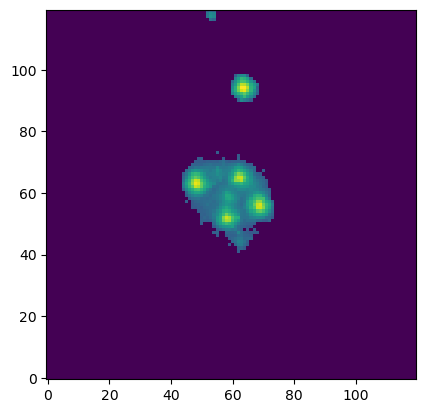

In [72]:
plt.imshow(ErrorMap_data, origin='lower', norm=LogNorm())

This whole procedure, without plotting is automated in the `generateErrorMap` function above - with just the three inputs. 

# Multiple Cutouts

now with multiple cutouts from regions (such as stars for STARRED) the `GenerateCutoutsAndErrorMaps` function returns a list with several HDUs. Each HDU has [0] the sci file cutout and [1] the corresponding errormap

 🔴 🔴 🔴 **NOTE: Automated Background reduction is enabled here!**  🔴 🔴 🔴

In [86]:

def GenerateCutoutsAndErrorMaps(hdul_sci, hdul_wht, ds9regionlist):
    """
    Generate cutouts and errormaps from a given list of DS9 regions.

    Parameters:
    - hdul_sci (astropy.io.fits.HDUList): The input FITS file containing the SCI data.
    - hdul_sci (astropy.io.fits.HDUList): The input FITS file containing the WHT data.
    - ds9regionlist (list): A list of DS9 regions. (any WCS)

    Returns:
    - cutouts_list (list): An list of hdul objects for every cutout, with the primary HDU containing the SCI Data and the second the WHT Data.
    """

    data = hdul_sci[0].data
    wht = hdul_wht[0].data
    header = hdul_sci[0].header
    wcs = WCS(header)
    cutouts_list=[]

    for i in range(len(ds9regionlist)):        
        if hasattr(ds9regionlist[i], 'to_pixel') == True:
            region_in_pix = ds9regionlist[i].to_pixel(wcs)
        else:
            region_in_pix = ds9regionlist[i]

        cutout_center_cord = region_in_pix.center.xy
        cutout_size = region_in_pix.height

        cutout_sci = Cutout2D(data, cutout_center_cord, cutout_size, wcs=wcs)
        cutout_sci_header = cutout_sci.wcs.to_header()
        hdul_sci_co = fits.HDUList([fits.PrimaryHDU(cutout_sci.data, cutout_sci_header)])
        hdul_sci_co=SubtractBG(hdul_sci_co)

        cutout_wht = Cutout2D(wht, cutout_center_cord, cutout_size, wcs=wcs)
        cutout_wht_header = cutout_wht.wcs.to_header()
        hdul_wht_co = fits.HDUList([fits.PrimaryHDU(cutout_wht.data, cutout_wht_header)])

        hdul_errormap=GenerateErrorMap(hdul_sci, hdul_sci_co, hdul_wht_co)

        hdul = fits.HDUList([hdul_sci_co[0], hdul_errormap[0]])
        
        cutouts_list.append(hdul)

    return cutouts_list

In [76]:
print("Select SCI File")
SCI_Path=tkinter.filedialog.askopenfilename()
scifile=fits.open(SCI_Path)

print("Select WHT File")
WHT_Path=tkinter.filedialog.askopenfilename()
whtfile=fits.open(WHT_Path)

print("Select region file for stars")
region_stars_path=tkinter.filedialog.askopenfilename()
region_stars=Regions.read(region_stars_path, format='ds9')

Select SCI File
Select WHT File
Select region file for stars


In [89]:
stars=GenerateCutoutsAndErrorMaps(scifile, whtfile, region_stars)

sigma_pedestal =  0.012174161488410483
sigma_pedestal =  0.010999577665116288
sigma_pedestal =  0.009552529717853133
sigma_pedestal =  0.009614067158588514
sigma_pedestal =  0.009168193271078953
sigma_pedestal =  0.0118533029503538
sigma_pedestal =  0.009231007421961776


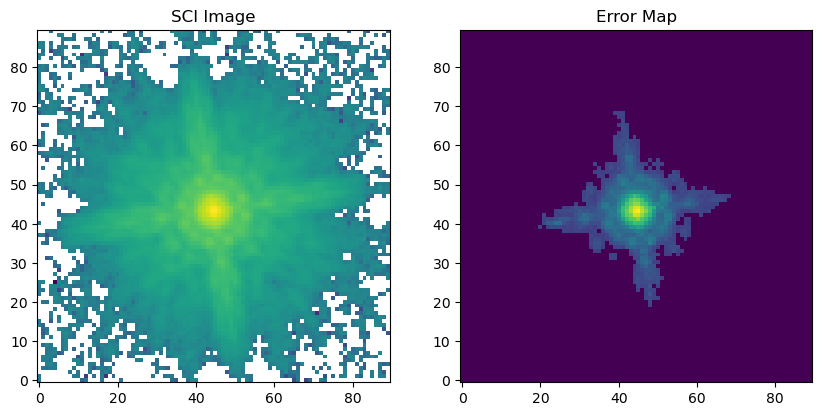

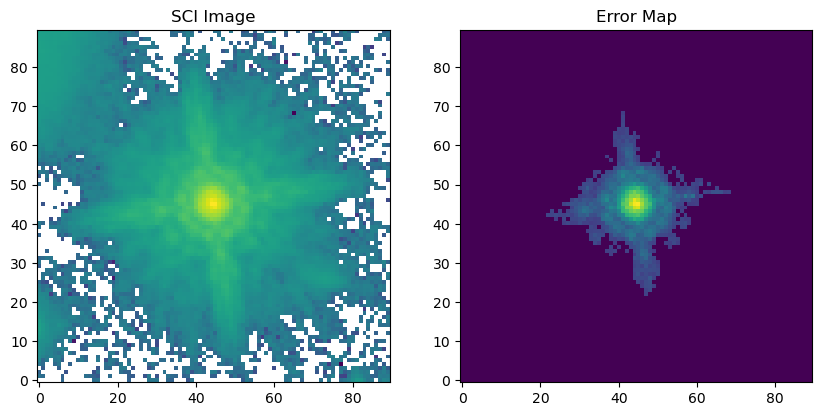

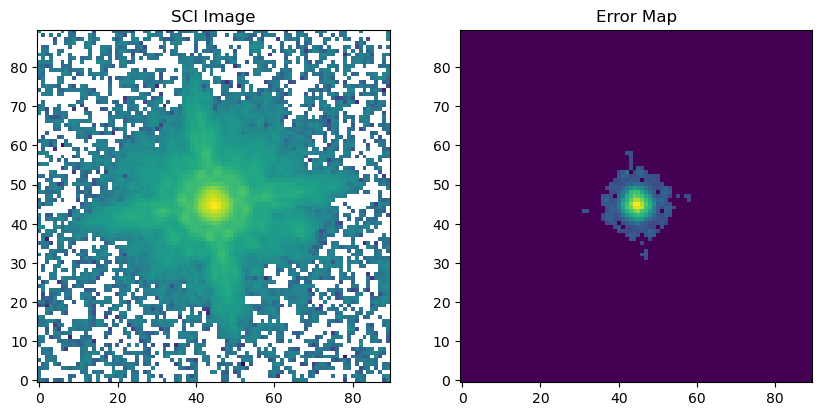

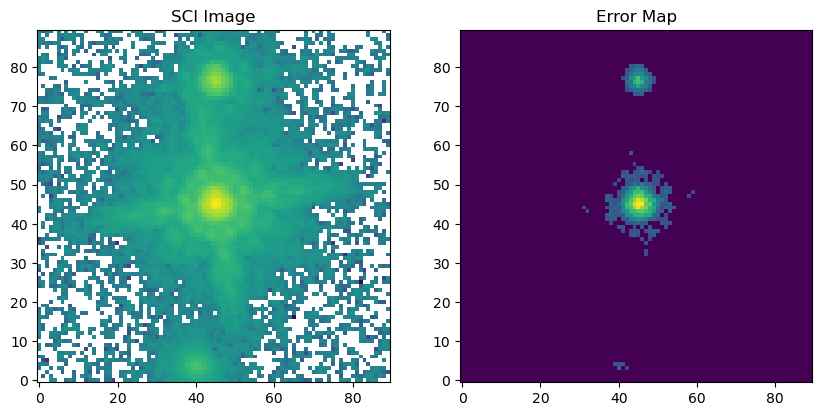

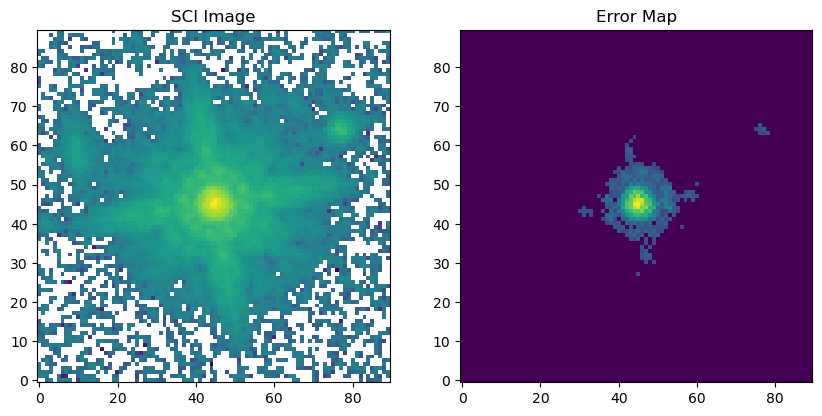

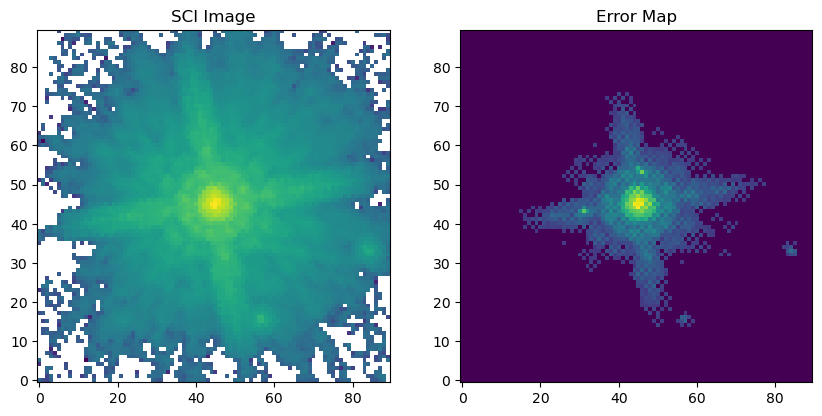

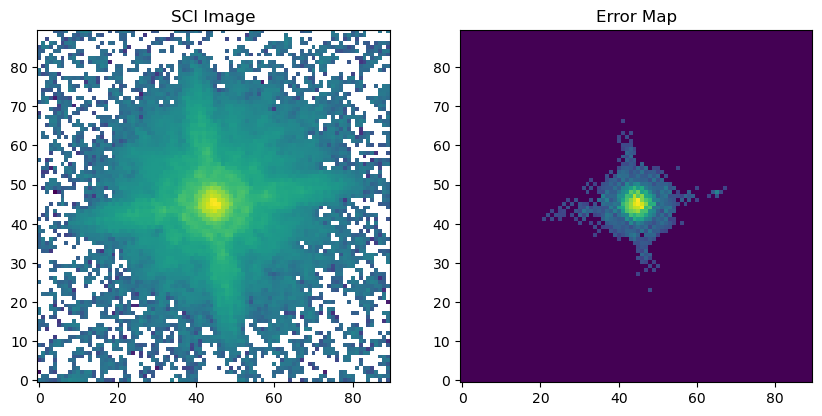

In [93]:

for star in stars:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
    
    # Plot star[0].data (SCI) on the first subplot
    axs[0].imshow(star[0].data, origin='lower', norm=LogNorm())
    axs[0].set_title('SCI Image')
    
    # Plot star[1].data (WHT) on the second subplot
    axs[1].imshow(star[1].data, origin='lower', norm=LogNorm())
    axs[1].set_title('Error Map')
    
    plt.show()